# Statistical Analysis of Image Deblurring Methods

This notebook analyzes the performance of different deblurring methods (Pseudoinverse, Wiener, DeblurGANv2) using a comprehensive statistical approach. We will explore descriptive statistics, hypothesis testing, confidence intervals, regression analysis, and visualizations to understand the strengths and weaknesses of each method.


## Single image example


In [1]:
from common.img_output import show_comparison
from common.config import BLUR_TYPES

single_image_key = "000000845"
single_image_method = "wiener"

show_comparison(
    key=single_image_key, 
    method=single_image_method, 
    blur_types=BLUR_TYPES, 
    cropped=False
)


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\dell\\Documents\\GitHub\\image-deblurring-performance-analysis\\data\\image-deblurring-performance-analysis\\test\\original\\00000\\000000845.png'

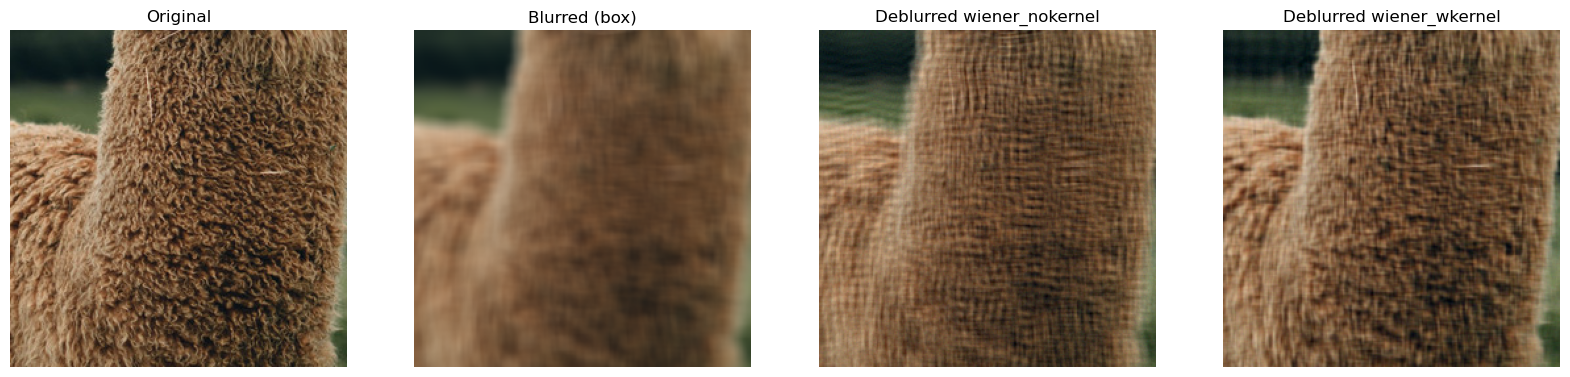

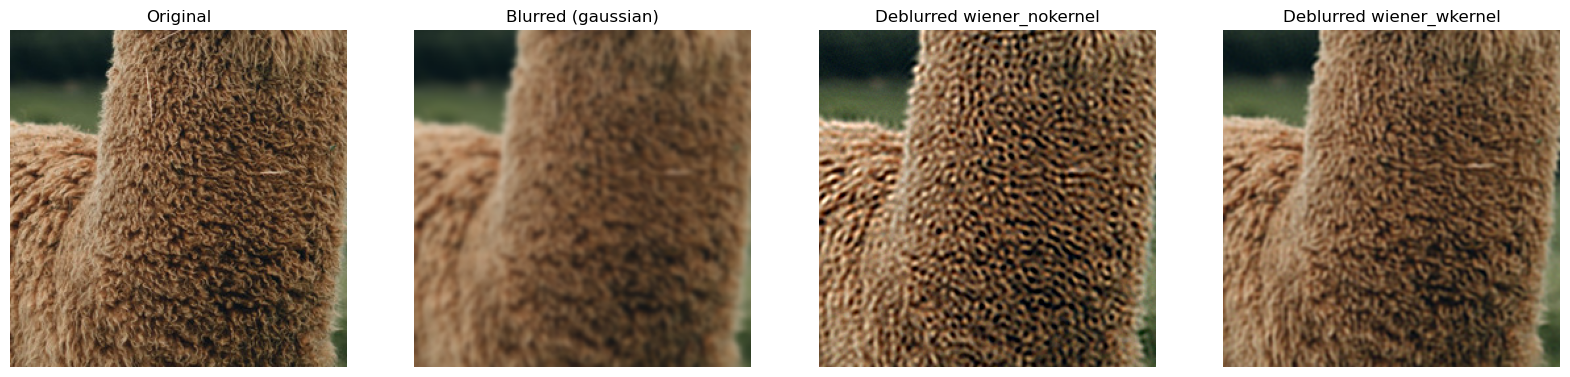

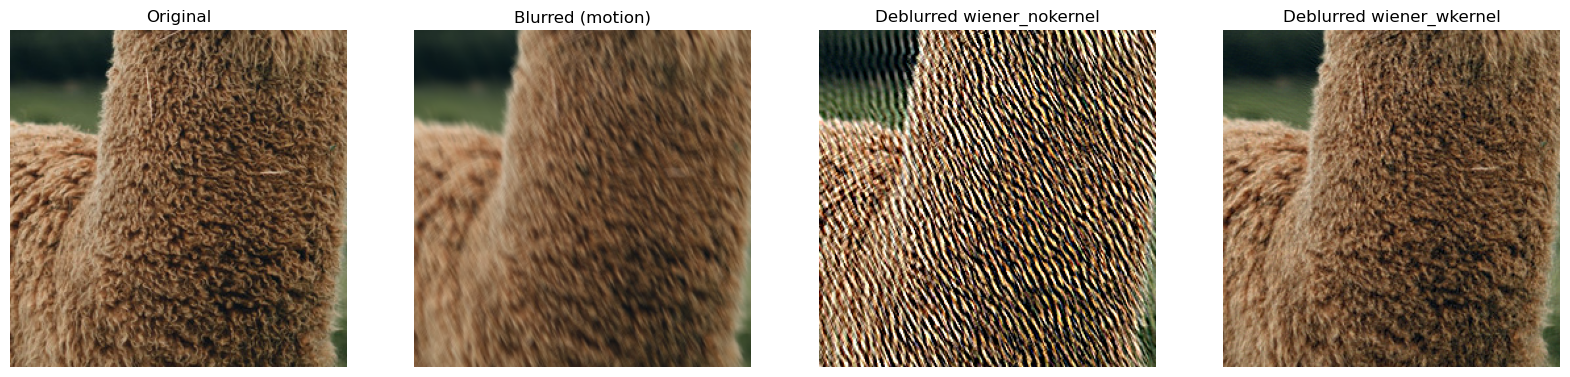

In [2]:
show_comparison(
    key=single_image_key, 
    method=single_image_method, 
    blur_types=BLUR_TYPES, 
    cropped=True
)

Load and merge metrics datasets with original one


## Preprocess


In [2]:
import pandas as pd
import numpy as np

from common.config import IDPA_DATASET, WIENER_NOKERNEL_DATASET, WIENER_WKERNEL_DATASET, DEBLURGANV2_DATASET, PSEUDOINVERSE_NOKERNEL_DATASET, PSEUDOINVERSE_WKERNEL_DATASET
from common.config import METRIC_TYPES, BLUR_TYPES

original_df = pd.read_parquet(IDPA_DATASET).dropna()

dfs = {
    'pseudoinverse_nokernel': pd.read_parquet(PSEUDOINVERSE_NOKERNEL_DATASET),
    'pseudoinverse_wkernel': pd.read_parquet(PSEUDOINVERSE_WKERNEL_DATASET),
    'wiener_nokernel': pd.read_parquet(WIENER_NOKERNEL_DATASET),
    'wiener_wkernel': pd.read_parquet(WIENER_WKERNEL_DATASET),
    'deblurganv2': pd.read_parquet(DEBLURGANV2_DATASET)
}

print(f"Image parameters: {original_df.shape}")
display(original_df.head(3))

print(f"Metrics for deblurganv2: {dfs["deblurganv2"].shape}")
display(dfs["deblurganv2"].head(3))

# merge original_df to each of the metrics df
for k in dfs.keys():
    dfs[k] = original_df.merge(dfs[k], on='key')

# Compute metric by computing average metric across blur types for each approach
for df in dfs.values():
    for metric in METRIC_TYPES:
        cols = [f'{metric}_{b}' for b in BLUR_TYPES if f'{metric}_{b}' in df.columns]
        df[metric] = df[cols].mean(axis=1)

Image parameters: (950, 16)


url  category        key  \
2  http://411posters.com/wp-content/uploads/2011/...    poster  000000382   
5  http://a.mktgcdn.com/p/0LhPt4Nq5I-vk_mT8U64np5...  withchar  000000931   
6  http://a1.espncdn.com/photo/2012/1113/mag_odog...   complex  000000558   

    width  height exif  aspect_ratio       size  rms_contrast  \
2  1300.0  1728.0   {}      0.752315  3169036.0      0.373365   
5  1680.0  1120.0   {}      1.500000  3369749.0      0.302635   
6  2048.0  1280.0   {}      1.600000  3899907.0      0.220292   

   sobel_edge_strength  canny_edge_density  box_size  gaussian_sigma  \
2            54.414061            0.139681      14.0        2.079159   
5            61.659178            0.114193       5.0        0.966656   
6            60.462335            0.090309      12.0        2.335230   

   gaussian_size  motion_length  motion_angle  
2           13.0           13.0    232.710817  
5            7.0           17.0    112.800705  
6           15.0           16.0    152.963697

Metrics for deblurganv2: (950, 16)


key  proctime_box  proctime_gaussian  proctime_motion  ssim_box  \
0  000000000      0.771006           0.227473         0.227028  0.624878   
1  000000002      0.243786           0.229896         0.233648  0.592647   
2  000000003      0.220997           0.182720         0.180572  0.716148   

    psnr_box  lpips_box  gmsd_box  ssim_gaussian  psnr_gaussian  \
0  21.736350   0.063853  0.269811       0.618547      21.525129   
1  22.730560   0.006872  0.227930       0.655491      23.634710   
2  25.098564   0.004474  0.189143       0.540464      21.949155   

   lpips_gaussian  gmsd_gaussian  ssim_motion  psnr_motion  lpips_motion  \
0        0.089766       0.278274     0.789718    24.130607      0.005149   
1        0.010482       0.216396     0.536058    21.578249      0.040192   
2        0.144286       0.256134     0.667576    23.922039      0.035748   

   gmsd_motion  
0     0.174958  
1     0.224285  
2     0.192016

## Descriptive statistics and Data exploration


We start by presenting describtion of the image features and average deblurring metrics for one method.


In [3]:
print("Image characteristics")
display(original_df.describe())

print("Metrics for the approach (deblurganv2)")
display(dfs["deblurganv2"][METRIC_TYPES].describe())

Image characteristics


width       height  aspect_ratio          size  rms_contrast  \
count   950.000000   950.000000    950.000000  9.500000e+02    950.000000   
mean   1556.865263  1361.677895      1.215505  3.510588e+06      0.241307   
std     461.015906   434.723050      0.383402  1.992244e+06      0.054723   
min     170.000000   117.000000      0.463392  7.694000e+03      0.060424   
25%    1223.000000  1080.000000      0.800500  2.274401e+06      0.204291   
50%    1500.000000  1280.000000      1.333333  3.223864e+06      0.239974   
75%    1920.000000  1600.000000      1.500000  4.179430e+06      0.277998   
max    4000.000000  4066.000000      3.200000  1.768750e+07      0.430649   

       sobel_edge_strength  canny_edge_density    box_size  gaussian_sigma  \
count           950.000000          950.000000  950.000000      950.000000   
mean             63.759947            0.128991   10.117895        2.199617   
std              25.274638            0.057644    3.151395        0.995533   
min               8.266673            0.000000    5.000000        0.515940   
25%              45.575302            0.088474    7.000000        1.348071   
50%              61.044392            0.123753   10.000000        2.155779   
75%              78.197440            0.162452   13.000000        3.062990   
max             203.722492            0.373182   15.000000        3.998513   

       gaussian_size  motion_length  motion_angle  
count     950.000000     950.000000    950.000000  
mean       13.461053      17.590526    183.191937  
std         5.549477       7.629577    103.763953  
min         5.000000       5.000000      0.618597  
25%         9.000000      11.000000     91.414728  
50%        13.000000      18.000000    181.171951  
75%        19.000000      24.000000    272.798978  
max        21.000000      30.000000    359.313659

Metrics for the approach (deblurganv2)


proctime        ssim        psnr       lpips        gmsd
count  950.000000  950.000000  950.000000  950.000000  950.000000
mean     0.274580    0.634974   22.102723    0.050283    0.216950
std      0.809060    0.137662    3.348279    0.048856    0.044791
min      0.049106    0.112772    9.474622    0.000850    0.065923
25%      0.177368    0.548582   19.889167    0.019259    0.188410
50%      0.214504    0.644560   21.794111    0.036673    0.222516
75%      0.275865    0.734541   24.139353    0.065703    0.250523
max     24.208056    0.955130   34.394935    0.467570    0.319597

We build pair plot for the metrics for one of the approaches.


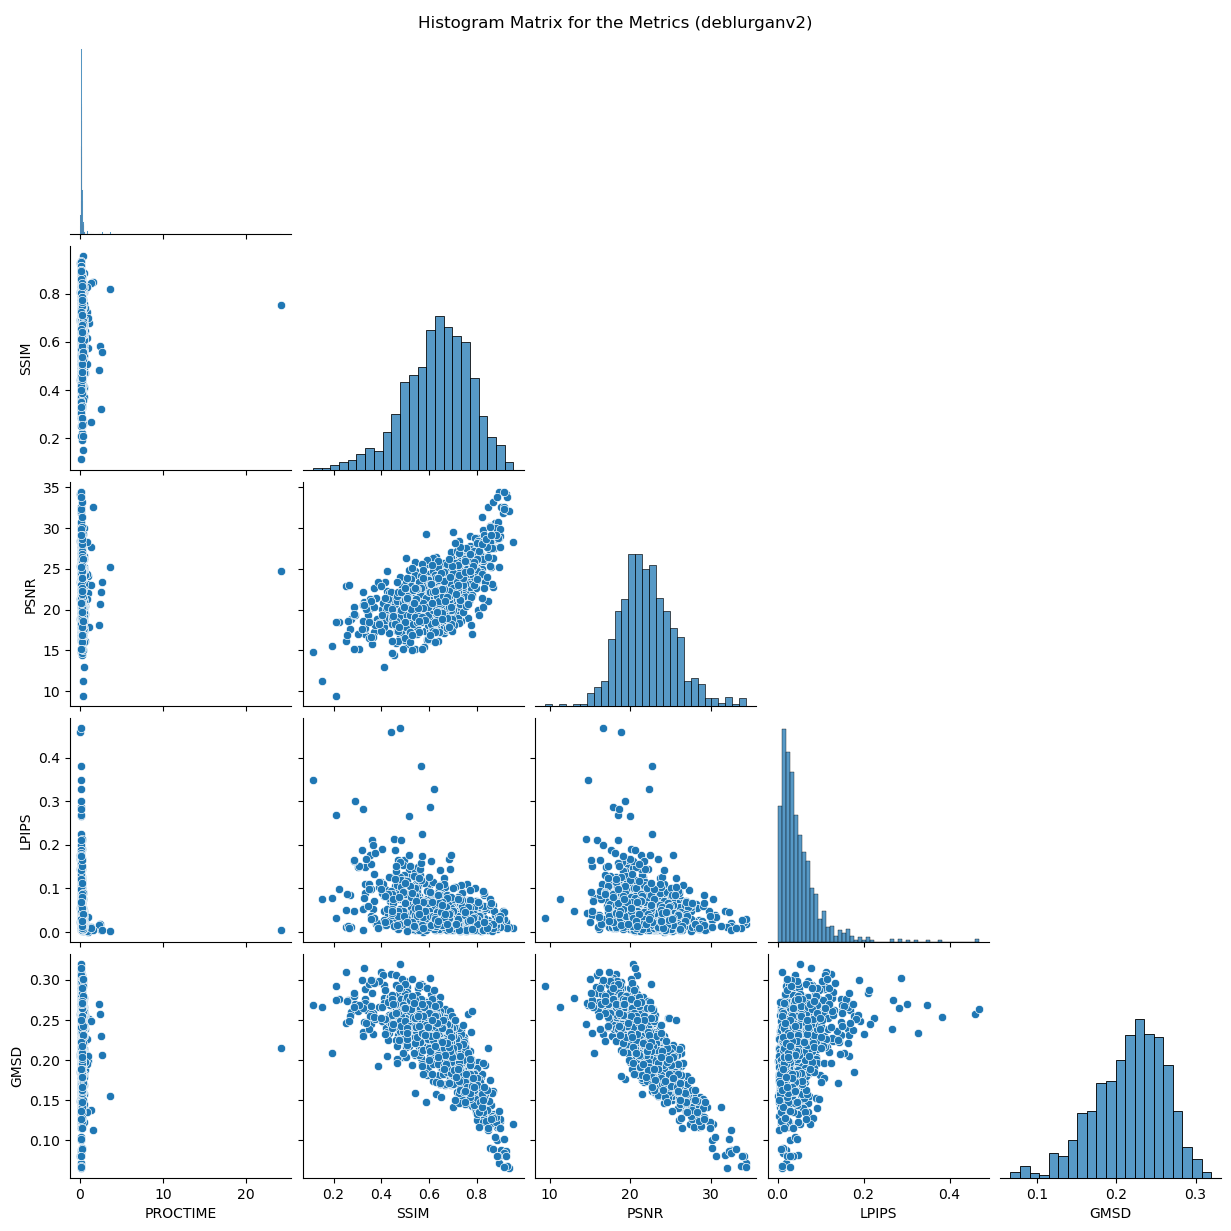

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

avg_cols_wk = [f'{metric}' for metric in METRIC_TYPES if f'{metric}' in dfs['deblurganv2'].columns]
plot_df_wk = dfs['deblurganv2'][avg_cols_wk].copy()
plot_df_wk.columns = [m.upper() for m in METRIC_TYPES]

sns.pairplot(plot_df_wk, diag_kind='hist', corner=True)
plt.suptitle('Histogram Matrix for the Metrics (deblurganv2)')
plt.show()

In [5]:
dfs["deblurganv2"].nlargest(10, "proctime")[["key", "proctime", "size", "width", "height"]]

key   proctime        size   width  height
680  000000478  24.208056  17687502.0  4000.0  4000.0
319  000000581   3.676692   7749483.0  2714.0  4066.0
515  000000352   2.718421  14886231.0  3840.0  2160.0
375  000000337   2.566817  16230722.0  3840.0  2160.0
331  000001179   2.377672  12103231.0  3500.0  2113.0
377  000001207   2.284155  15721443.0  2399.0  3036.0
537  000001222   1.613782   6531868.0  2890.0  2410.0
837  000000821   1.375062  12412303.0  3000.0  2254.0
712  000000842   1.344908   8472127.0  3500.0  2100.0
101  000001165   1.098550   9060934.0  3050.0  2308.0

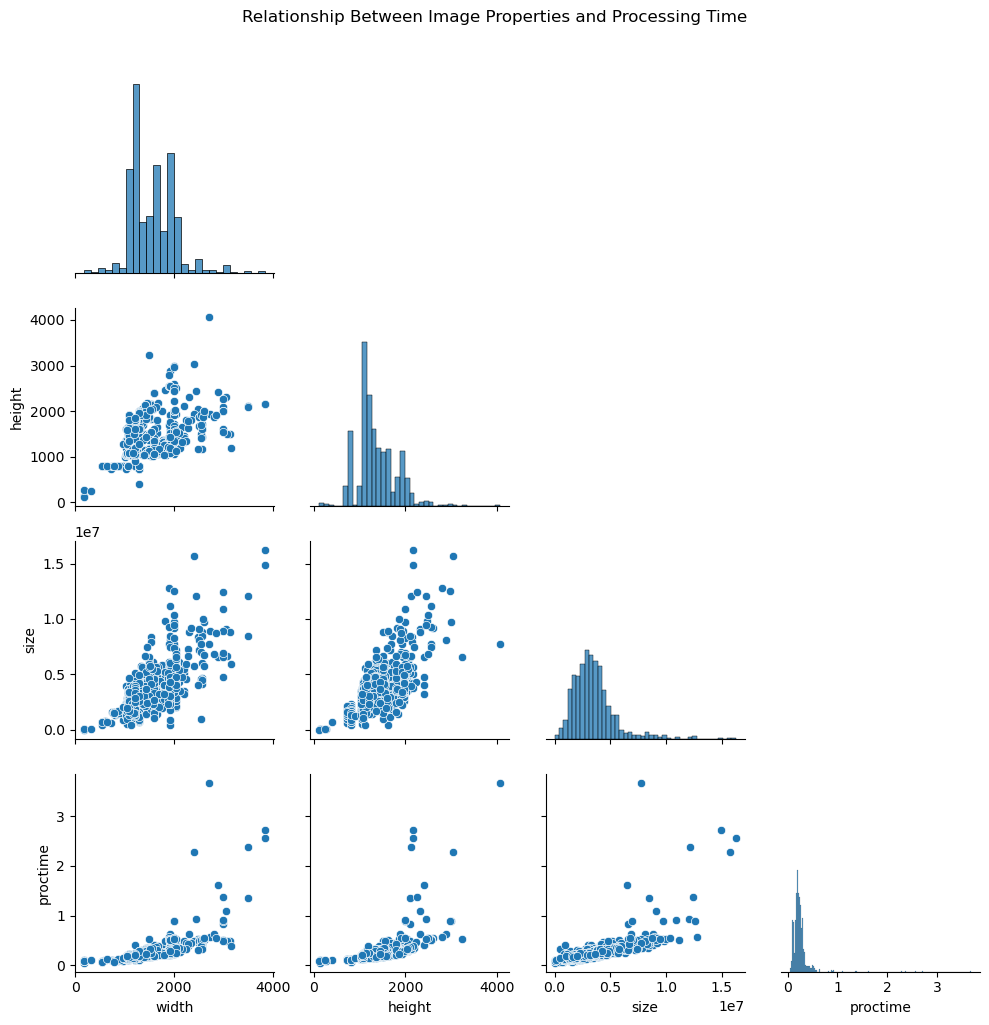

In [6]:
import seaborn as sns

import matplotlib.pyplot as plt

plot_cols = ['width', 'height', 'size', 'proctime']

outlier_idx = dfs['deblurganv2']['proctime'].idxmax()

for df_name in dfs.keys():
    dfs[df_name] = dfs[df_name].drop(outlier_idx)

g = sns.pairplot(dfs['deblurganv2'][plot_cols], diag_kind='hist', corner=True)
plt.suptitle('Relationship Between Image Properties and Processing Time', y=1.02)
plt.tight_layout()
plt.show()

To confirm our assumptions about the correlation of the metrics we compute a correlation heat map for each metric across all methods. The correlation is computed using the Pearson coefficient.

The Pearson correlation coefficient, denoted as $\rho$ for the population and $r$ for the sample, measures the linear relationship between two variables $X$ and $Y$. It is calculated as:

$$
\rho = \frac{\mathrm{Cov}(X, Y)}{\sigma_X \sigma_Y}
$$

where $\mathrm{Cov}(X, Y)$ is the covariance between $X$ and $Y$, and $\sigma_X$, $\sigma_Y$ are the standard deviations of $X$ and $Y$, respectively. The value of $r$ ranges from $-1$ (perfect negative linear correlation) to $+1$ (perfect positive linear correlation), with $0$ indicating no linear correlation.


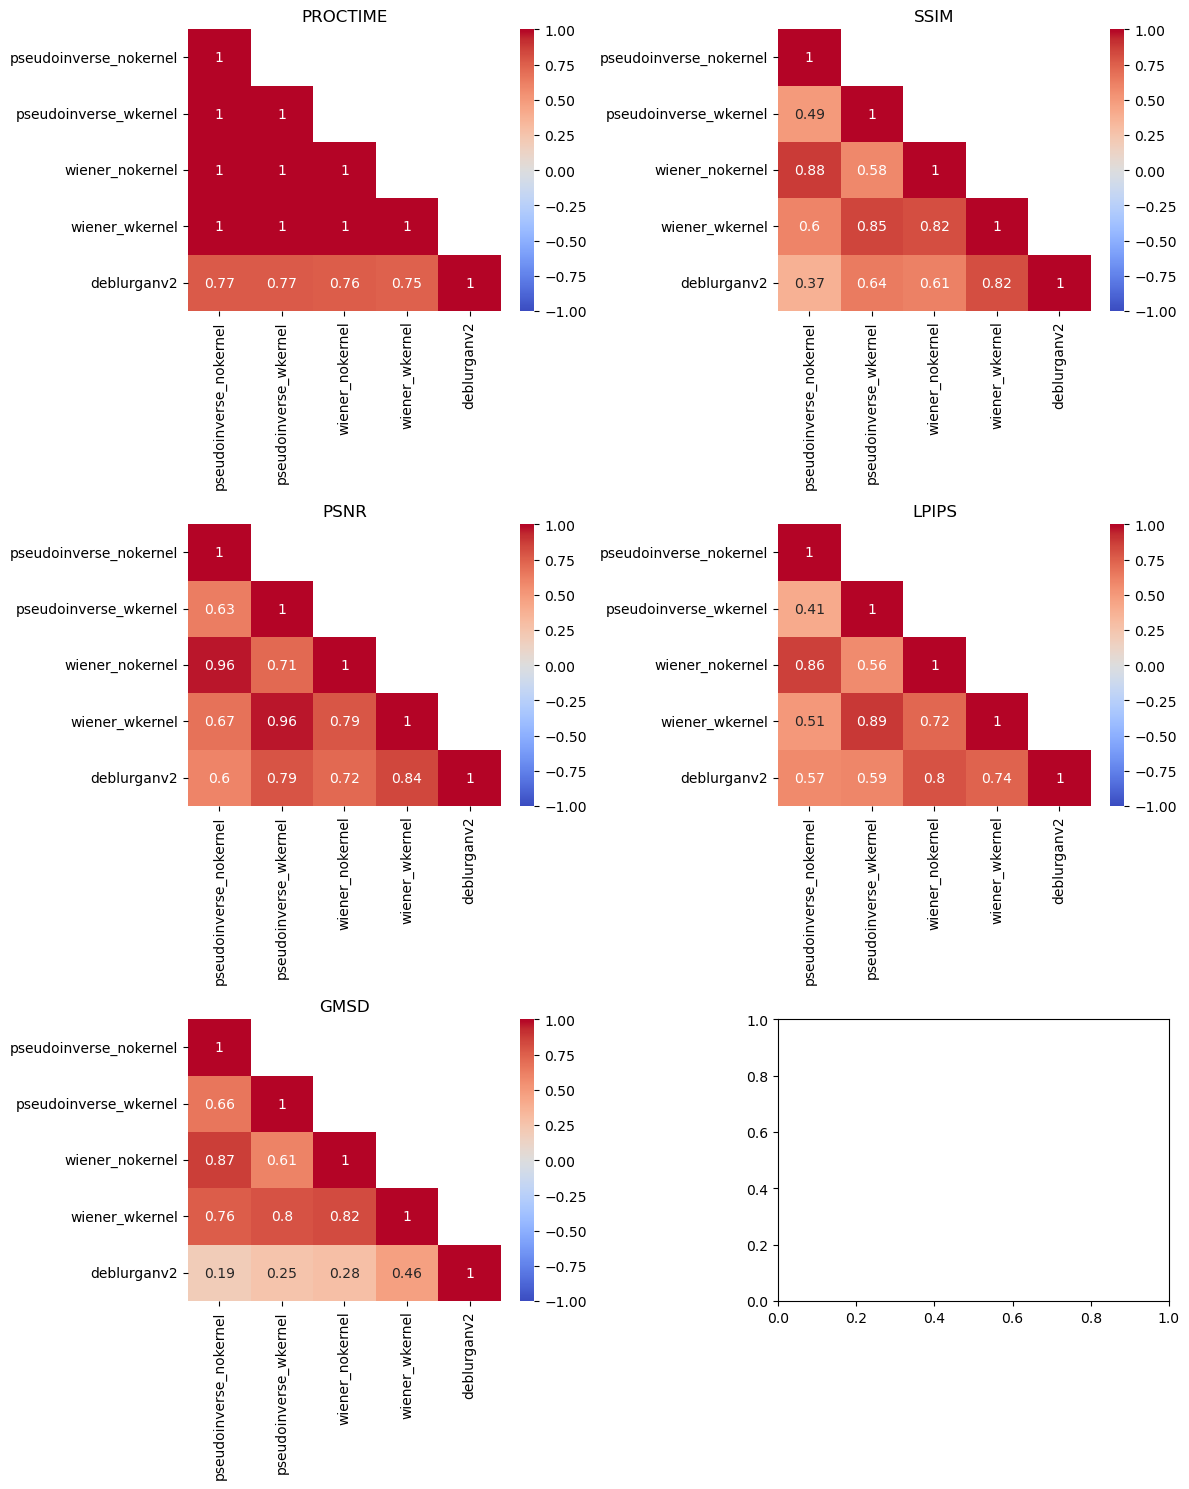

In [7]:
n_metrics = len(METRIC_TYPES)
n_cols = 2
n_rows = (n_metrics + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 5 * n_rows))
axes = axes.flatten()

for i, metric in enumerate(METRIC_TYPES):
    data = pd.DataFrame({
        method: df[metric] for method, df in dfs.items()
    })
    corr = data.corr()
    mask = np.triu(np.ones_like(corr, dtype=bool), k=1)
    sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1, mask=mask, ax=axes[i])
    axes[i].set_title(metric.upper())

plt.tight_layout()
plt.show()

We compute boxplots across methods for each metric to compare the performance of each method considering metrics separately.


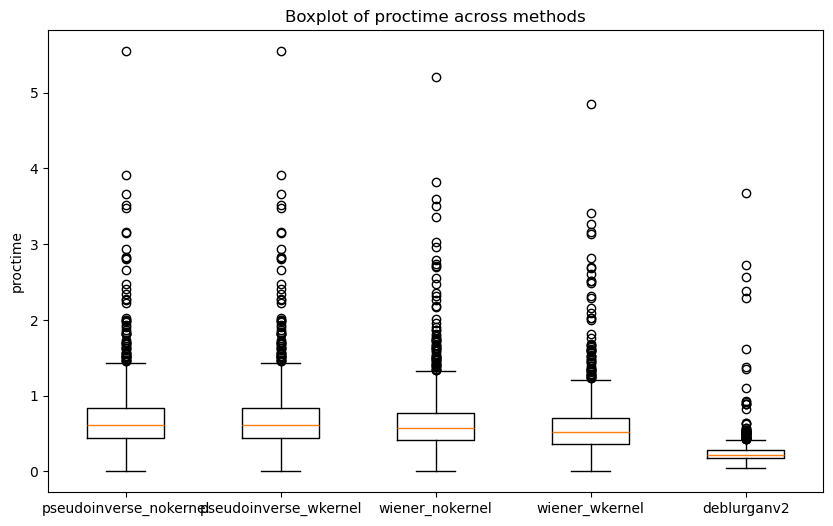

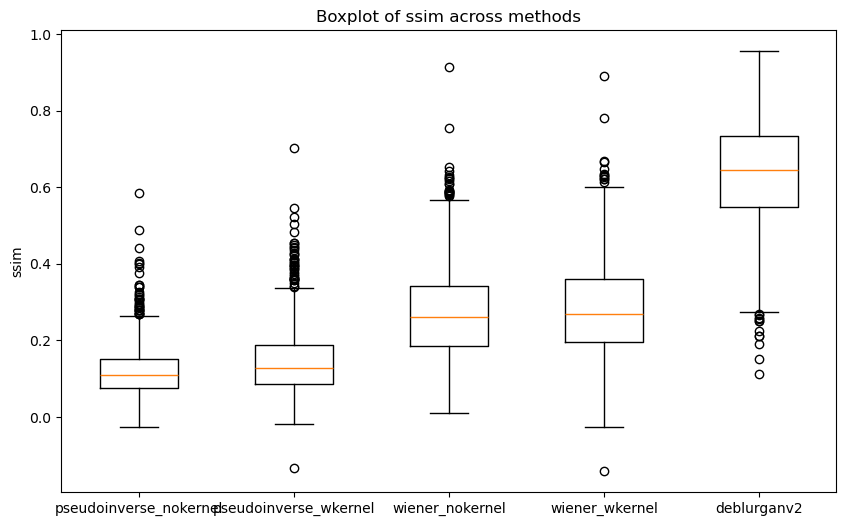

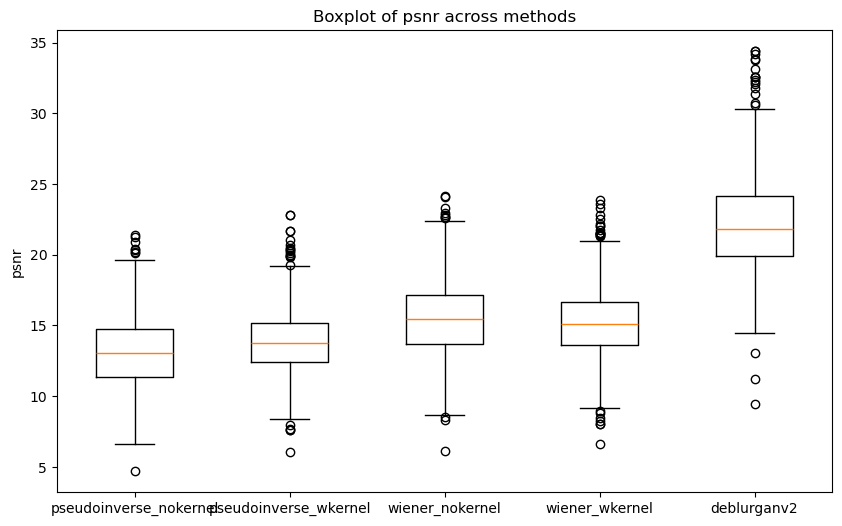

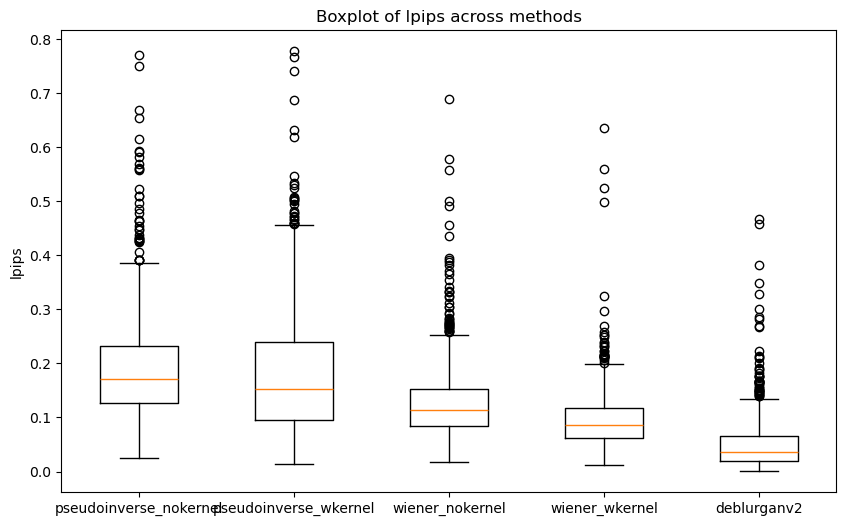

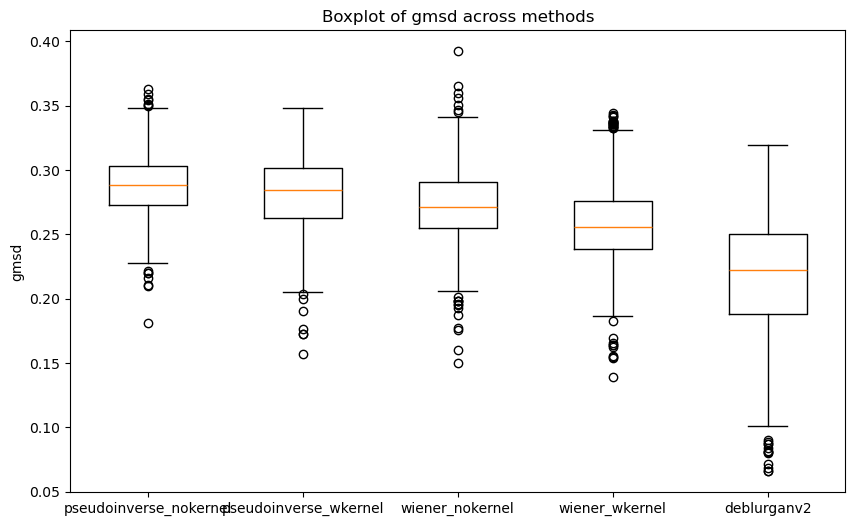

In [8]:
for metric in METRIC_TYPES:
    plt.figure(figsize=(10, 6))
    data = [df[metric] for df in dfs.values()]
    plt.boxplot(data, tick_labels=dfs.keys())
    plt.title(f'Boxplot of {metric} across methods')
    plt.ylabel(metric)
    plt.show()

We confirm the assumptions about performance by comparing the means of each metric.


In [9]:
display(pd.DataFrame({
    method: [df[metric].mean() for metric in METRIC_TYPES]
    for method, df in dfs.items()
}, index=METRIC_TYPES))

pseudoinverse_nokernel  pseudoinverse_wkernel  wiener_nokernel  \
proctime                0.708261               0.708261         0.668106   
ssim                    0.121344               0.146681         0.273878   
psnr                   13.100672              13.852488        15.536871   
lpips                   0.190885               0.179899         0.127103   
gmsd                    0.288286               0.281192         0.272836   

          wiener_wkernel  deblurganv2  
proctime        0.605277     0.249360  
ssim            0.283181     0.634849  
psnr           15.168785    22.099893  
lpips           0.095224     0.050332  
gmsd            0.257926     0.216951

## 3. Hypothesis Testing and Power Analysis

Now we compare the performance of methods using paired tests on average metrics.

### Hypothesis Testing on `lpips_motion`

We performed an independent t-test to evaluate whether the average `lpips_motion` metric differs significantly based on the motion angle.

---

#### Test: High vs Low Motion Angle in Wiener (No Kernel)

Let $\mu_1$ be the mean lpips metric for the motion blur for images with a motion angle greater than 180°  
and $\mu_2$ be the mean lpips metric for the motion blur for images with a motion angle of 180° or lower.

**$H_0$:** $\mu_1 = \mu_2$  
**$H_1$:** $\mu_1 \neq \mu_2$

**t-statistic:** (value from test)  
**p-value:** (value from test)

A non-significant p-value indicates that there is no statistically significant difference between the two groups.

In [10]:
from scipy.stats import ttest_ind

group1 = dfs["wiener_nokernel"][dfs["wiener_nokernel"]["motion_angle"] > 180]["lpips_motion"]
group2 = dfs["wiener_nokernel"][dfs["wiener_nokernel"]["motion_angle"] <= 180]["lpips_motion"]

t1, p1 = ttest_ind(group1, group2)

print(f"T-statistic: {t1}")
print(f"P-value: {p1}")

T-statistic: -1.5880930730350467
P-value: 0.11259909037840973


### Hypothesis Testing 1: Paired t-test (Wiener with kernel vs without kernel) — SSIM

We want to verify whether using the kernel in the Wiener method leads to improved performance compared to the version without kernel, considering the **SSIM** metric.

**Definitions:**
- $X_1$: SSIM for Wiener **with kernel**
- $X_2$: SSIM for Wiener **without kernel**
- $D = X_1 - X_2$: difference in metrics for each image

**Hypotheses:**

- $H_0$: $\mu_D = 0$  
    (No average improvement, or Wiener with kernel performs the same or worse than the version without kernel)
- $H_1$: $\mu_D < 0$  
    (Wiener with kernel has a lower mean SSIM than the version without kernel)

**Test used:**  
Paired t-test (one-tailed, left)

In [10]:
from scipy.stats import ttest_rel, t

metric = "ssim"

ssim_wk = dfs["wiener_wkernel"][metric]
ssim_nk = dfs["wiener_nokernel"][metric]

# 1. Hypotheses
print("1. Hypotheses:")
print(f"   H0: μ_d = 0 (no difference in {metric} between Wiener with and without kernel)")
print(f"   H1: μ_d < 0 (Wiener with kernel has LOWER {metric})")

# 2. Acceptance region (one-tailed, left)
alpha = 0.05
n = len(ssim_wk)
df = n - 1
t_critical = t.ppf(alpha, df)
print(f"\n2. Acceptance region:")
print(f"   Reject H0 if t < {t_critical:.4f} (alpha = {alpha})")

# 3. Test statistic
stat, p_value_two_tailed = ttest_rel(ssim_wk, ssim_nk)
print(f"\n3. Test statistic:")
print(f"   t = {stat:.4f}")

# 4. Decision
print("\n4. Decision:")
if stat < t_critical:
    print(f"   Reject H0: There is evidence Wiener with kernel has LOWER {metric}.")
else:
    print("   Fail to reject H0: No evidence Wiener with kernel is worse.")

# 5. p-value (one-tailed, left tail)
p_value_one_tailed = p_value_two_tailed / 2
print(f"\n5. p-value (one-tailed, left): {p_value_one_tailed}")


1. Hypotheses:
   H0: μ_d = 0 (no difference in ssim between Wiener with and without kernel)
   H1: μ_d < 0 (Wiener with kernel has LOWER ssim)

2. Acceptance region:
   Reject H0 if t < -1.6465 (alpha = 0.05)

3. Test statistic:
   t = 3.7767

4. Decision:
   Fail to reject H0: No evidence Wiener with kernel is worse.

5. p-value (one-tailed, left): 8.440679571281921e-05


### Paired confidence interval

The confidence interval estimate for the mean of paired differences is:

\[
\bar{d} \pm t_{n-1,\,1-\alpha/2} \cdot \frac{s_d}{\sqrt{n}}
\]

where:
- $\bar{d}$ is the mean of the differences,
- $s_d$ is the standard deviation of the differences,
- $n$ is the number of pairs,
- $t_{n-1,\,1-\alpha/2}$ is the quantile of the Student's t-distribution with $n-1$ degrees of freedom.

In [16]:
import numpy as np
from scipy.stats import t

# 99% confidence interval for the mean of the differences D = X1 - X2 (SSIM Wiener with kernel - without kernel)

D = ssim_wk - ssim_nk
D = D.dropna()
n = len(D)
mean_D = D.mean()
std_D = D.std()
se_D = std_D / np.sqrt(n)
confidence_level = 0.99
alpha = 1 - confidence_level
df = n - 1

t_critical = t.ppf(1 - alpha/2, df)
margin_error = t_critical * se_D
ci_lower = mean_D - margin_error
ci_upper = mean_D + margin_error

print(f"99% confidence interval for the mean of the differences (D = SSIM_wk - SSIM_nk):")
print(f"[{ci_lower:.4f}, {ci_upper:.4f}]")
print(f"Mean of the differences: {mean_D:.4f}")
print(f"Does the interval contain zero? {'Yes' if ci_lower <= 0 <= ci_upper else 'No'}")

99% confidence interval for the mean of the differences (D = SSIM_wk - SSIM_nk):
[0.0029, 0.0157]
Mean of the differences: 0.0093
Does the interval contain zero? No


### Hypothesis Testing 2: Independent t-test (DeblurGANv2 vs Wiener without kernel) — LPIPS (Motion Blur Only)

We want to verify whether the average perceptual quality (LPIPS) for **motion blur** obtained with DeblurGANv2 is significantly different (lower, thus better) compared to Wiener without kernel.

**Definitions:**
- $X_1$: LPIPS (motion blur) for DeblurGANv2
- $X_2$: LPIPS (motion blur) for Wiener without kernel

**Hypotheses:**

- $H_0$: $\mu_1 = \mu_2$  
    (There is no significant difference between DeblurGANv2 and Wiener without kernel for motion blur)
- $H_1$: $\mu_1 < \mu_2$  
    (DeblurGANv2 has a lower, thus better, mean LPIPS than Wiener without kernel for motion blur)

**Test used:**  
Independent two-sample t-test (one-tailed, left)

In [24]:
from scipy.stats import ttest_ind, t

metric = "lpips_motion"

lpips_dg = dfs["deblurganv2"][metric]
lpips_nk = dfs["wiener_nokernel"][metric]

# 1. Hypotheses
print("1. Hypotheses:")
print(f"   H0: μ1 = μ2 (no difference in {metric} between DeblurGANv2 and Wiener no kernel)")
print(f"   H1: μ1 < μ2 (DeblurGANv2 has LOWER {metric})")

# 2. Acceptance region (one-tailed, left)
alpha = 0.05
n1, n2 = len(lpips_dg), len(lpips_nk)
s1 = lpips_dg.std()
s2 = lpips_nk.std()
df = (s1**2/n1 + s2**2/n2)**2 / ((s1**2/n1)**2/(n1-1) + (s2**2/n2)**2/(n2-1))
t_critical = t.ppf(alpha, df)
print(f"\n2. Acceptance region:")
print(f"   Reject H0 if t < {t_critical:.4f} (alpha = {alpha})")

# 3. Test statistic
stat, p_value_one_tailed = ttest_ind(lpips_dg, lpips_nk, equal_var=False, alternative='less')
print(f"\n3. Test statistic:")
print(f"   t = {stat:.4f}")

# 4. Decision
print("\n4. Decision:")
if stat < t_critical:
    print(f"   Reject H0: There is evidence DeblurGANv2 has LOWER {metric}.")
else:
    print("   Fail to reject H0: No evidence DeblurGANv2 is better.")

# 5. p-value (one-tailed, left tail)
print(f"\n5. p-value (one-tailed, left): {p_value_one_tailed:}")

1. Hypotheses:
   H0: μ1 = μ2 (no difference in lpips_motion between DeblurGANv2 and Wiener no kernel)
   H1: μ1 < μ2 (DeblurGANv2 has LOWER lpips_motion)

2. Acceptance region:
   Reject H0 if t < -1.6460 (alpha = 0.05)

3. Test statistic:
   t = -39.2796

4. Decision:
   Reject H0: There is evidence DeblurGANv2 has LOWER lpips_motion.

5. p-value (one-tailed, left): 4.269237045438823e-225


In [25]:
from scipy.stats import norm
import numpy as np

# Parameters for the test
# lpips_dg and lpips_nk are already defined as the two data series
n1 = len(lpips_dg)
n2 = len(lpips_nk)
alpha = 0.05  # significance level

# Minimum relevant difference (delta): you can choose a value, e.g., the observed difference
delta = lpips_dg.mean() - lpips_nk.mean()

# Pooled standard deviation
s1 = lpips_dg.std()
s2 = lpips_nk.std()
s_pooled = np.sqrt(((n1 - 1)*s1**2 + (n2 - 1)*s2**2) / (n1 + n2 - 2))

# Standard error of the difference
se = s_pooled * np.sqrt(1/n1 + 1/n2)

# Critical threshold for left-tailed test
z_alpha = norm.ppf(alpha)

# Mean of the statistic under the alternative
mu_Z1 = delta / se

# Power calculation
power = norm.cdf(z_alpha, loc=mu_Z1, scale=1)

print(f"Test power (z-test approximation): {power}")

Test power (z-test approximation): 1.0


In [26]:
import numpy as np
from scipy.stats import t

X1 = lpips_dg.dropna()
X2 = lpips_nk.dropna()
n1, n2 = len(X1), len(X2)
mean1, mean2 = X1.mean(), X2.mean()
std1, std2 = X1.std(ddof=1), X2.std(ddof=1)

# Estimate of the standard error (Welch's t-test, unequal variances)
se_diff = np.sqrt(std1**2/n1 + std2**2/n2)
mean_diff = mean1 - mean2

# Degrees of freedom (Welch-Satterthwaite equation)
df_diff = (std1**2/n1 + std2**2/n2)**2 / ((std1**2/n1)**2/(n1-1) + (std2**2/n2)**2/(n2-1))

# 99% confidence interval
confidence_level = 0.99
alpha = 1 - confidence_level
t_critical_diff = t.ppf(1 - alpha/2, df_diff)
margin_error_diff = t_critical_diff * se_diff
ci_lower_diff = mean_diff - margin_error_diff
ci_upper_diff = mean_diff + margin_error_diff

print(f"99% CI for mean difference (DeblurGANv2 - Wiener no kernel) on LPIPS_motion:")
print(f"[{ci_lower_diff:.4f}, {ci_upper_diff:.4f}]")
print(f"Mean difference: {mean_diff:.4f}")
print(f"Does the interval contain zero? {'Yes' if ci_lower_diff <= 0 <= ci_upper_diff else 'No'}")

99% CI for mean difference (DeblurGANv2 - Wiener no kernel) on LPIPS_motion:
[-0.1517, -0.1330]
Mean difference: -0.1424
Does the interval contain zero? No


### Hypothesis Testing 3: Difference in Proportions — Threshold Exceedance

We want to verify whether **DeblurGANv2** exceeds a quality threshold (e.g., GMSD < 0.15) **more often** than Wiener **without kernel**, considering only the **motion blur** case.

**Definitions:**
- $p_1$: Proportion of images with GMSD\_motion < 0.15 for DeblurGANv2
- $p_2$: Proportion of images with GMSD\_motion < 0.15 for Wiener without kernel

**Hypotheses:**

- $H_0$: $p_1 = p_2$  
    (The proportions of success are equal)
- $H_1$: $p_1 \neq p_2$  
    (The proportions are different)

**Test used:**  
z-test for proportions (on GMSD\_motion)

In [22]:
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import norm

metric = "gmsd_motion"
threshold = 0.15

# 1. Hypotheses:
print("1. Hypotheses:")
print(f"   H0: p1 = p2 (DeblurGANv2 and Wiener no kernel have the same proportion of images with {metric.upper()} < {threshold})")
print(f"   H1: p1 ≠ p2 (The proportions are different)")

# Calculate proportions GMSD < threshold
success_ai = (dfs['deblurganv2'][metric] < threshold).sum()
n_ai = dfs['deblurganv2'][metric].notna().sum()
success_nk = (dfs['wiener_nokernel'][metric] < threshold).sum()
n_nk = dfs['wiener_nokernel'][metric].notna().sum()

count = [success_ai, success_nk]
nobs = [n_ai, n_nk]

# 2. Acceptance region (two-tailed, alpha=0.05)
alpha = 0.05
z_critical = norm.ppf(1 - alpha/2)
print(f"\n2. Acceptance region:")
print(f"   Reject H0 if |z| > {z_critical:.4f} (alpha = {alpha})")

# 3. Test statistic
stat, p_value = proportions_ztest(count, nobs)
print(f"\n3. Test statistic:")
print(f"   z = {stat:.4f}")

# 4. Decision
print("\n4. Decision:")
if abs(stat) > z_critical:
    print("   Reject H0: There is a significant difference in proportions.")
else:
    print("   Fail to reject H0: No significant difference in proportions.")

# 5. p-value
print(f"\n5. p-value: {p_value:.4e}")

print(f"\nDeblurGANv2: {success_ai}/{n_ai} ({success_ai/n_ai:.2%})")
print(f"Wiener no kernel: {success_nk}/{n_nk} ({success_nk/n_nk:.2%})")


1. Hypotheses:
   H0: p1 = p2 (DeblurGANv2 and Wiener no kernel have the same proportion of images with GMSD_MOTION < 0.15)
   H1: p1 ≠ p2 (The proportions are different)

2. Acceptance region:
   Reject H0 if |z| > 1.9600 (alpha = 0.05)

3. Test statistic:
   z = 10.8368

4. Decision:
   Reject H0: There is a significant difference in proportions.

5. p-value: 2.3033e-27

DeblurGANv2: 116/949 (12.22%)
Wiener no kernel: 2/949 (0.21%)


In [ ]:
from statsmodels.stats.proportion import confint_proportions_2indep

# 99% confidence interval for the difference in proportions (p1 - p2)
alpha_ci = 0.01  # 99% CI
ci_low, ci_upp = confint_proportions_2indep(
    count1=success_ai, nobs1=n_ai,
    count2=success_nk, nobs2=n_nk,
    method='wald', alpha=alpha_ci
)

print(f"99% confidence interval for the difference in proportions (DeblurGANv2 - Wiener no kernel):")
print(f"[{ci_low:.4f}, {ci_upp:.4f}]")
print(f"Observed difference: {(success_ai/n_ai - success_nk/n_nk):.4f}")

99% confidence interval for the difference in proportions (DeblurGANv2 - Wiener no kernel):
[0.0939, 0.1502]
Observed difference: 0.1201


## 4. Confidence Intervals

We compute 99% confidence intervals to control the consistency with hypothesis tests.


## 5. Linear Regression Analysis

We model the relationship between image features/blur parameters and average deblurring metrics. Visualize regression fit and residuals.


In [12]:
# import statsmodels.api as sm

# # Example: Predict SSIM_avg for DeblurGANv2
# target = 'ssim'
# X = dfs['deblurganv2'][feature_cols]
# X = sm.add_constant(X)
# y = dfs['deblurganv2'][target]
# model = sm.OLS(y, X, missing='drop').fit()
# print(model.summary())

# # Visualization: predicted vs actual, residuals
# y_pred = model.predict(X)
# plt.figure(figsize=(6,4))
# plt.scatter(y_pred, y, alpha=0.5)
# plt.xlabel('Predicted SSIM')
# plt.ylabel('Actual SSIM')
# plt.title('Regression: Predicted vs Actual (DeblurGANv2)')
# plt.plot([y.min(), y.max()], [y.min(), y.max()], '--', color='gray')
# plt.show()

# residuals = y - y_pred
# plt.figure(figsize=(6,4))
# plt.scatter(y_pred, residuals, alpha=0.5)
# plt.axhline(0, color='gray', linestyle='--')
# plt.xlabel('Predicted SSIM')
# plt.ylabel('Residuals')
# plt.title('Regression Residuals (DeblurGANv2)')
# plt.show()

## 6. Conclusions


# Prove

In [47]:
import statsmodels.api as sm

predictor = 'sobel_edge_strength'
target = 'ssim_motion'

X = dfs['deblurganv2'][[predictor]].dropna()
y = dfs['deblurganv2'].loc[X.index, target]
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            ssim_motion   R-squared:                       0.265
Model:                            OLS   Adj. R-squared:                  0.265
Method:                 Least Squares   F-statistic:                     341.9
Date:                Mon, 26 May 2025   Prob (F-statistic):           2.03e-65
Time:                        14:11:11   Log-Likelihood:                 672.95
No. Observations:                 949   AIC:                            -1342.
Df Residuals:                     947   BIC:                            -1332.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.8294    

In [ ]:
target = 'ssim_motion'
features = ['rms_contrast', 'size', 'sobel_edge_strength', 'canny_edge_density']

X = dfs['deblurganv2'][features].dropna()
y = dfs['deblurganv2'].loc[X.index, target]
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            ssim_motion   R-squared:                       0.396
Model:                            OLS   Adj. R-squared:                  0.393
Method:                 Least Squares   F-statistic:                     154.8
Date:                Mon, 26 May 2025   Prob (F-statistic):          8.04e-102
Time:                        14:19:37   Log-Likelihood:                 765.95
No. Observations:                 949   AIC:                            -1522.
Df Residuals:                     944   BIC:                            -1498.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.8142    

In [55]:
import statsmodels.api as sm
import pandas as pd

target = 'ssim_motion'

X_cat = pd.get_dummies(dfs['deblurganv2']['category'], drop_first=True).astype(float)
y = dfs['deblurganv2'][target]

df_reg = pd.concat([X_cat, y], axis=1).dropna()
X = sm.add_constant(df_reg.drop(target, axis=1))
y = df_reg[target]

model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            ssim_motion   R-squared:                       0.080
Model:                            OLS   Adj. R-squared:                  0.069
Method:                 Least Squares   F-statistic:                     6.824
Date:                Mon, 26 May 2025   Prob (F-statistic):           6.62e-12
Time:                        14:24:47   Log-Likelihood:                 566.47
No. Observations:                 949   AIC:                            -1107.
Df Residuals:                     936   BIC:                            -1044.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.6638      0.014     47.983   

In [38]:
import statsmodels.api as sm
import pandas as pd

features = ['rms_contrast', 'size', 'sobel_edge_strength', 'canny_edge_density']
X_num = dfs['deblurganv2'][features]
X_cat = pd.get_dummies(dfs['deblurganv2']['category'], drop_first=True).astype(float)

X_full = pd.concat([X_num, X_cat], axis=1)
y_full = dfs['deblurganv2']['ssim_motion']
df_reg = pd.concat([X_full, y_full], axis=1).dropna()

X = sm.add_constant(df_reg.drop('ssim_motion', axis=1))
y = df_reg['ssim_motion']

model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            ssim_motion   R-squared:                       0.414
Model:                            OLS   Adj. R-squared:                  0.404
Method:                 Least Squares   F-statistic:                     41.11
Date:                Mon, 26 May 2025   Prob (F-statistic):           1.81e-96
Time:                        14:00:47   Log-Likelihood:                 780.06
No. Observations:                 949   AIC:                            -1526.
Df Residuals:                     932   BIC:                            -1444.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.8213    

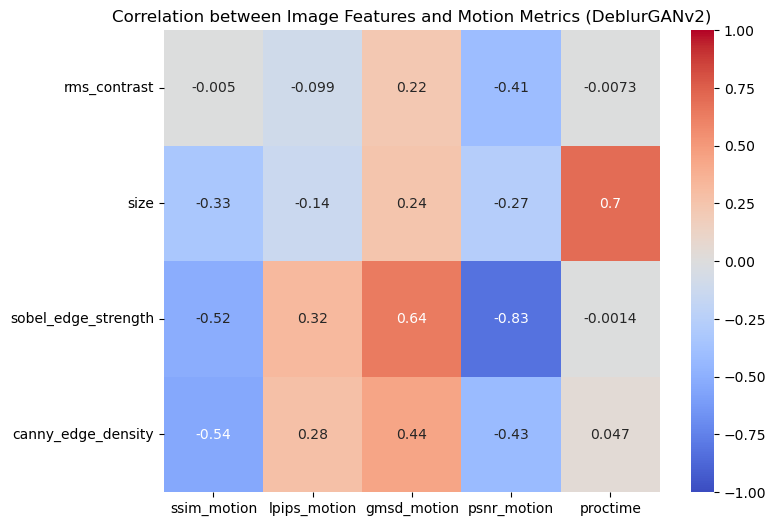

In [68]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calcola la matrice di correlazione tra le feature principali e le metriche motion di DeblurGANv2
features = ['rms_contrast', 'size', 'sobel_edge_strength', 'canny_edge_density']
metrics = ['ssim_motion', 'lpips_motion', 'gmsd_motion', 'psnr_motion', 'proctime']

corr_df = dfs['deblurganv2'][features + metrics].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_df.loc[features, metrics], annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation between Image Features and Motion Metrics (DeblurGANv2)')
plt.show()

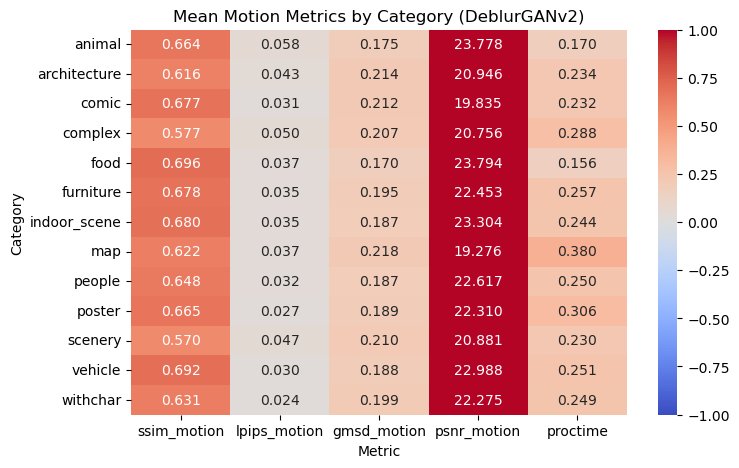

In [75]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calcola la media delle metriche motion per ciascuna categoria
metrics = ['ssim_motion', 'lpips_motion', 'gmsd_motion', 'psnr_motion', 'proctime']
category_means = dfs['deblurganv2'].groupby('category')[metrics].mean()

plt.figure(figsize=(8, 5))
sns.heatmap(category_means, annot=True, cmap="coolwarm", fmt=".3f", vmin=-1, vmax=1)
plt.title('Mean Motion Metrics by Category (DeblurGANv2)')
plt.ylabel('Category')
plt.xlabel('Metric')
plt.show()